<a href="https://colab.research.google.com/github/lucianosilva-github/compiladores/blob/main/Solu%C3%A7%C3%A3o-ProjetoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#PROJETO COMPILADOR MINI PASCAL

#Nome: Bernardo Galvão
#TIA: 41827368

### GRAMÁTICA IMPLEMENTADA

program ::= program id ( identifier_list ) ;
  	    declarations
	    subprogram_declarations
	    compound_statement
	    .

identifier_list ::= id
	| identifier_list , id


declarations ::= declarations var identifier_list : type ;
	| lambda


type ::= standard_type
	| array [ num .. num ] of type


standard_type ::= integer
	| real
        | string


subprogram_declarations ::=
	subprogram_declarations subprogram_declaration ;
	| lambda


subprogram_declaration ::=
	subprogram_head 
	declarations 			
        compound_statement

subprogram_head ::= function id arguments : standard_type ;
	| procedure id arguments ;


arguments ::= ( parameter_list )
	| lambda


parameter_list ::= identifier_list : type
	| parameter_list ; identifier_list : type


compound_statement ::= begin
		       optional_statements
		       end


optional_statements ::= statement_list
	| lambda


statement_list ::= statement
	| statement_list ; statement


statement ::= variable := expression
	| procedure_statement
	| compound_statement
	| if expression then statement else statement
	| while expression do statement


variable ::= id tail

tail     ::= [ expression ] tail
	| lambda 


procedure_statement ::= id
	| id ( expression_list )


expression_list ::= expression
	| expression_list , expression


expression ::= simple_expression
	| simple_expression relop simple_expression


simple_expression ::= term
	| simple_expression addop term


term ::= factor
	| term mulop factor


factor ::= id tail
	| id ( expression_list )
	| num
	| ( expression )
	| not factor


addop ::= + | -


mulop ::= * | div



relop ::= <
	| >
	| =
	| <=
	| >=
	| <>


In [5]:
!pip install rply

In [6]:
from rply import LexerGenerator
from rply.token import BaseBox
from rply import ParserGenerator

In [7]:
#ANALISADOR LÉXICO

lg = LexerGenerator()


#-------------Gerais------------------------------------

lg.add('NUMBER', r'\d+')
lg.add('CHARCONST', r'\'\S\'')
lg.add('CHARCONST', r'\"\S+\"')

lg.add('SEMI_COLON', r'\;')
lg.add('ASSIGNMENT', r'\:\=')
lg.add('COLON', r'\:')
lg.add('COMMA', r'\,')
lg.add('DOUBLE_DOT', r'[.]{2}')
lg.add('OPEN_PARENS', r'\(')
lg.add('CLOSE_PARENS', r'\)')
lg.add('TRUE', r'true')
lg.add('FALSE', r'false')


#-------------<program>---------------------------------
lg.add('PROGRAM', r'program')
lg.add('DOT', r'\.')


#-------------<variable declaration part>---------------
lg.add('VAR', r'var')
#arrays
lg.add('ARRAY', r'array')
lg.add('OF', r'of')
lg.add('OPEN_BRACKETS', r'\[')
lg.add('CLOSE_BRACKETS', r'\]')
#data types
lg.add('CHAR', r'char')
lg.add('INTEGER', r'integer')
lg.add('BOOLEAN', r'boolean')


#-------------<subroutine declaration part>-------------
lg.add('PROCEDURE', r'procedure')
lg.add('FUNCTION', r'function')


#-------------<statement part>--------------------------
lg.add('BEGIN', r'begin')
lg.add('END', r'end')


#-------------<simple statement>------------------------
lg.add('READ', r'read')
lg.add('WRITE', r'write')


#-------------<structured statement>---------------------
#IFs
lg.add('IF', r'if')
lg.add('THEN', r'then')
lg.add('ELSE', r'else')
#whiles
lg.add('WHILE', r'while')
lg.add('DO', r'do')

#-------------<operators>---------------------
#logical
lg.add('NOT', r'not')
lg.add('AND', r'and')
lg.add('OR', r'or')
lg.add('GREATER_EQUALS', r'=>')
lg.add('EQUALS', r'=')
lg.add('LESSER_EQUALS', r'<=')
lg.add('DIFF', r'<>')
lg.add('GREATER', r'\>')
lg.add('LESSER', r'\<')
#algebric
lg.add('PLUS', r'\+')
lg.add('MINUS', r'-')
lg.add('MUL', r'\*')
lg.add('DIV', r'div')

lg.add('ID', r'[a-zA-Z][a-zA-Z0-9]*')

lg.ignore('\s+')

lexer = lg.build()

In [8]:
#TESTANDO O ANALISADOR LÉXICO

for token in lexer.lex(""" '1' "a1a" 'a' "a" := 1"""):
    print(token)

Token('CHARCONST', "'1'")
Token('CHARCONST', '"a1a"')
Token('CHARCONST', "'a'")
Token('CHARCONST', '"a"')
Token('ASSIGNMENT', ':=')
Token('NUMBER', '1')


In [9]:
#CLASSES PARA REPRESENTAÇÃO DOS NÓS DA ÁRVORE SINTÁTICA

class Program(BaseBox):
    def __init__(self, identifier, declarations, subprogram_declarations, compound_stmt):
        self.id = identifier
        self.declarations = declarations
        self.subprogram_declarations = subprogram_declarations
        self.compound_stmt = compound_stmt

        
    def print(self):
        print("---------------------PROGRAM-------------------")
        print("ID: " + self.id)  
        print("\n------------------DECLARATIONS-------------------")
        self.declarations.print()
        print("\n-----------------SUBPROGRAM DECLARATIONS-------------------")
        self.subprogram_declarations.print()
        print("\n------------------COMPOUND STATEMENT---------------------")
        self.compound_stmt.print()
        
    def accept(self, visitor):
        visitor.visit_prog(self)
            
    
    
class Empty(BaseBox):
    def __init__(self):
        pass
      
    def print(self):
        pass
    
    def accept(self, visitor):
        pass

    
    
class Id(BaseBox):
    def __init__(self, value):
        self.value = value
    
    def print(self):
        print("ID: " + self.value)
    
        

class Id_List(BaseBox):
    def __init__(self, head, tail):
        self.head = head
        self.tail = tail
        
    def print(self):
        print("ID: " + self.head)
        self.tail.print()
        
    def accept(self, visitor):
        visitor.visit_id_list(self)

        
        
class Declaration(BaseBox):
    def __init__(self, id, ids, dtype):
        self.id = id
        self.ids = ids
        self.type = dtype
        
    def print(self):
        print("\n----VAR----")
        self.id.print()
        print("TYPE: " + self.type)
        self.ids.print()
        
    def accept(self, visitor):
        visitor.visit_declaration(self)

        
        
class Parameter(BaseBox):
    def __init__(self, id, dtype):
        self.id = id
        self.type = dtype
        
    def print(self):
        self.id.print()
        print("TYPE: " + self.type)   
    
    def accept(self, visitor):
        visitor.visit_param(self)
    
    
class Parameter_List(BaseBox):
    def __init__(self, id, ids, dtype):
        self.id = id
        self.ids = ids
        self.type = dtype
        
    def print(self):
        self.id.print()
        print("TYPE: " + self.type)
        self.ids.print()
        
    def accept(self, visitor):
        visitor.visit_param_list(self)
        
        

class Function_Head(BaseBox):
    def __init__(self, id, params, dtype):
        self.id = id
        self.params = params
        self.type = dtype
    
    def print(self):
        print("ID: " + self.id)
        print("\n----PARAMS----")
        self.params.print()
        print("\n----RETURN----")
        print("TYPE: " + self.type)
    
    def accept(self, visitor):
        visitor.visit_func_head(self)
        
        

class Procedure_Head(BaseBox):
    def __init__(self, id, params):
        self.id = id
        self.params = params
        
    def print(self):
        print("\n----PROCEDURE----")
        print("ID: " + self.id)
        print("\n----PARAMS----")
        self.params.print()
    
    def accept(self, visitor):
        visitor.visit_proc_head(self)
 

        
class Subprogram_Declaration(BaseBox):
    def __init__(self, subprogram_head, declarations, compound_stmt):
        self.subprogram_head = subprogram_head
        self.declarations = declarations
        self.compound_stmt = compound_stmt
        
    def print(self):
        print("\n------------------FUNCTION---------------------")
        self.subprogram_head.print()
        self.declarations.print()
        self.compound_stmt.print()
        print("\n-----------------END FUNCTION--------------------")
        
    def accept(self, visitor):
        visitor.visit_subprogram_decl(self)

        
        
class Subprogram_Declarations(BaseBox):
    def __init__(self, head, tail):
        self.head = head
        self.tail = tail

    def print(self):
        self.head.print()
        self.tail.print()
        
    def accept(self, visitor):
        visitor.visit_subprogram_decls(self)

        
        
class Stmt_List(BaseBox):
    def __init__(self, stmt, stmts):
        self.stmt = stmt
        self.stmts = stmts
        
    def print(self):
        self.stmt.print()
        self.stmts.print()
        
    def accept(self, visitor):
        visitor.visit_stmt_list(self)
     
    
    
class Assig_Stmt(BaseBox):
    def __init__(self, var, expr):
        self.var = var
        self.expr = expr
        
    def print(self):
        print("\n----ASSIGNMENT----")
        print("\nLEFT: ", end="")
        self.var.print()
        print("\nRIGHT: ", end="")
        self.expr.print()
        
    def accept(self, visitor):
        visitor.visit_assig(self)
        
     
    
class Loop_Stmt(BaseBox):
    def __init__(self, expr, stmt):
        self.expr = expr
        self.stmt = stmt
        
    def print(self):
        print("\n----WHILE----")
        self.expr.print()
        print("\n----DO----")
        self.stmt.print()
        
    def accept(self, visitor):
        visitor.visit_loop(self)


        
class Cond_Stmt(BaseBox):
    def __init__(self, expr, stmt, alt_stmt):
        self.expr = expr
        self.stmt = stmt
        self.alt_stmt = alt_stmt
        
    def print(self):
        print("\n----IF----")
        self.expr.print()
        print("\n----THEN----")
        self.stmt.print()
        print("\n----ELSE----")
        self.alt_stmt.print()
    
    def accept(self, visitor):
        visitor.visit_cond(self)
        

class Expr(BaseBox):
    def accept(self, visitor):
        method_name = 'visit_{}'.format(self.__class__.__name__.lower())
        visit = getattr(visitor, method_name)
        visit(self)
        
    
class Var(Expr):
    def __init__(self, id, tail):
        self.id = id
        self.tail = tail
        
    def print(self):
        print("ID: ", self.id)
        self.tail.print()
    

    
class Tail(BaseBox):
    def __init__(self, expr, tail):
        self.expr = expr
        self.tail = tail
        
    def print(self):
        self.expr.print()
        self.tail.print()
        
        
        
class Proc_Stmt(Expr):
    def __init__(self, id, expr_list):
        self.id = id
        self.expr_list = expr_list
        
    def print(self):
        print("\n----CHAMADA DE FUNCAO----")
        print("ID: ", self.id)
        print("\n----PARAMS----")
        self.expr_list.print()
    
        
              
class Expr_List(BaseBox):
    def __init__(self, expr, expr_list):
        self.expr = expr
        self.expr_list = expr_list
        
    def print(self):
        self.expr.print()
        self.expr_list.print() 
        
        
        
class BinaryOp(Expr):
    def __init__(self, left, right):
        self.left = left
        self.right = right
        
    def print(self):
        print("\n----RELOP----")
        print("\nLEFT: ", end="")
        self.left.print()
        print("\nRIGHT: ", end="")
        self.right.print()     
        
        
class Add(BinaryOp):
    def print(self):
        print("\n----ADD OP----")
        print("\nLEFT: ", end="")
        self.left.print()
        print("\nRIGHT: ", end="")
        self.right.print()    
        
    

class Sub(BinaryOp):
    def print(self):
        print("\n----SUB OP----")
        print("\nLEFT: ", end="")
        self.left.print()
        print("\nRIGHT: ", end="")
        self.right.print()

        
class Mul(BinaryOp):
    def print(self):
        print("\n----MUL OP----")
        print("\nLEFT: ", end="")
        self.left.print()
        print("\nRIGHT: ", end="")
        self.right.print()   
        


class Div(BinaryOp):
    def print(self):
        print("\n----DIV OP----")
        print("\nLEFT: ", end="")
        self.left.print()
        print("\nRIGHT: ", end="")
        self.right.print()   
        

               
class Token(Expr):
    def __init__(self, value):
        self.value = value 
        
    def print(self):
        print(self.value)
    
    


In [11]:
#ANALISADOR SINTÁTICO

pg = ParserGenerator(
    # A list of all token names, accepted by the lexer.
    ['ID', 'NUMBER', 'CHARCONST', 'SEMI_COLON', 'ASSIGNMENT', 'COLON',
     'COMMA', 'DOUBLE_DOT', 'OPEN_PARENS', 'CLOSE_PARENS', 'TRUE',
     'FALSE', 'PROGRAM', 'DOT', 'VAR', 'ARRAY', 'OF', 'OPEN_BRACKETS',
     'CLOSE_BRACKETS', 'CHAR', 'INTEGER', 'BOOLEAN', 'PROCEDURE',
     'FUNCTION', 'BEGIN', 'END', 'IF', 'THEN', 'ELSE', 'END',
     'WHILE', 'DO', 'NOT', 'AND', 'OR', 'GREATER_EQUALS', 'EQUALS', 
     'LESSER_EQUALS', 'DIFF', 'GREATER', 'LESSER', 'PLUS', 'MINUS',
     'MUL', 'DIV'
    ],
    # A list of precedence rules with ascending precedence, to
    # disambiguate ambiguous production rules.
    precedence=[
        ('left', ['OR']), 
        ('left', ['AND']),
        ('left', ['EQUALS', 'DIFF']),
        ('left', ['GREATER', 'LESSER', 'GREATER_EQUALS', 'LESSER_EQUALS']), 
        ('left', ['PLUS', 'MINUS']),
        ('left', ['MUL', 'DIV'])    
    ]
)


@pg.error
def error_handler(token):
    raise ValueError("Token wasn't expected: "+token.name+" "+token.value+" "+str(token.source_pos))

    
    
# program ::= program id ; declarations subprogram_declarations compound_stmt .
@pg.production('program : PROGRAM ID SEMI_COLON declarations subprogram_declarations compound_stmt DOT')
def program(p):
    return Program(p[1].getstr(), p[3], p[4], p[5])
    


#identifier_list : id | id, identifier_list
@pg.production('identifier_list : ID')
@pg.production('identifier_list : identifier_list COMMA ID')
def identifier_list(p):
    if len(p) > 1:
        return Id_List(p[2].getstr(), p[0])
    else:
        return Id(p[0].getstr())
        
       
    
#declarations ::= VAR identifier_list : type ; declarations | empty
@pg.production('declarations : declarations VAR identifier_list COLON type SEMI_COLON')
@pg.production('declarations :')
def declarations(p):
    try:
        return Declaration(p[2], p[0], p[4])
    except:
        return Empty()



#type ::= standard_type | array [number .. number] of type
@pg.production('type : standard_type')   
@pg.production('type : ARRAY OPEN_BRACKETS NUMBER DOUBLE_DOT NUMBER CLOSE_BRACKETS OF type')
def type(p):
    if len(p) > 1:
        return p[7]
    else:
        return p[0] 

    
    
#standatd_type ::= integer | char | boolean
@pg.production('standard_type : INTEGER')
@pg.production('standard_type : CHAR')
@pg.production('standard_type : BOOLEAN')
def standard_type(p):
    return p[0].getstr()
    
    
#subprogram_declarations ::= subprogram_declarations subprogram_declaration ; | lambda
@pg.production('subprogram_declarations : subprogram_declarations subprogram_declaration SEMI_COLON')
@pg.production('subprogram_declarations :')
def subprogram_declarations(p):
    try:
        return Subprogram_Declarations(p[1], p[0])
    except:
        return Empty()
    
    
#subprogram_declaration ::= subprogram_head  declarations compound_statement
@pg.production('subprogram_declaration : subprogram_head declarations compound_stmt')    
def subprogram_declaration(p):
    return Subprogram_Declaration(p[0], p[1], p[2])


#subprogram_head ::= function id arguments : standard_type ; | procedure id arguments ;
@pg.production('subprogram_head : FUNCTION ID arguments COLON standard_type SEMI_COLON')
@pg.production('subprogram_head : PROCEDURE ID arguments SEMI_COLON')
def subprogram_head(p):
    if len(p) == 4:
        return Procedure_Head(p[1].getstr(), p[2])
    else:
        return Function_Head(p[1].getstr(), p[2], p[4])


#arguments ::= ( parameter_list ) | lambda   
@pg.production('arguments : OPEN_PARENS parameter_list CLOSE_PARENS')
@pg.production('arguments :')
def arguments(p):
    try:
        return p[1]
    except:
        return Empty()
    
    
#parameter_list ::= identifier_list : type | parameter_list ; identifier_list : type
@pg.production('parameter_list : identifier_list COLON type')
@pg.production('parameter_list : parameter_list SEMI_COLON identifier_list COLON type')
def parameter_list(p):
    if len(p) == 3:
        return Parameter(p[0], p[2])
    else:
        return Parameter_List(p[2], p[0], p[4])
    
    
#compound_statement ::= begin optional_statements end
@pg.production('compound_stmt : BEGIN optional_stmts END')
def compound_stmt(p):
    return p[1]


#optional_statements ::= statement_list | lambda
@pg.production('optional_stmts : stmt_list')
@pg.production('optional_stmts :')
def optional_stmts(p):
    try:
        return p[0]
    except:
        return Empty()
    
    
#statement_list ::= statement | statement_list ; statement
@pg.production('stmt_list : stmt')
@pg.production('stmt_list : stmt_list SEMI_COLON stmt')
def stmt_list(p):
    if len(p) == 1:
        return p[0]
    else:
        return Stmt_List(p[2], p[0])


#statement ::= variable := expression | procedure_statement | compound_statement | if expression then statement else statement | while expression do statement    
@pg.production('stmt : variable ASSIGNMENT expression')
@pg.production('stmt : procedure_stmt')
@pg.production('stmt : compound_stmt')
@pg.production('stmt : IF expression THEN stmt ELSE stmt')
@pg.production('stmt : WHILE expression DO stmt')
def stmt(p):
    l = len(p)
    if l == 1:
        return p[0]
    elif l == 3:
        return Assig_Stmt(p[0], p[2])
    elif l == 4:
        return Loop_Stmt(p[1], p[3])
    elif l == 6:
        return Cond_Stmt(p[1], p[3], p[5])
        

#variable ::= id tail
@pg.production('variable : ID tail')
def variable(p):
    return Var(p[0].getstr(), p[1])


#tail ::= [ expression ] tail | lambda 
@pg.production('tail : OPEN_BRACKETS expression CLOSE_BRACKETS tail')
@pg.production('tail :')
def tail(p):
    try:
        return Tail(p[1], p[3])
    except:
        return Empty()
    
    
#procedure_statement ::= id | id ( expression_list )
@pg.production('procedure_stmt : ID')
@pg.production('procedure_stmt : ID OPEN_PARENS expression_list CLOSE_PARENS')
def procedure_stmt(p):
    if len(p) > 1:
        return Proc_Stmt(p[0].getstr(), p[2])
    else:
        return Id(p[0].getstr())


#expression_list ::= expression | expression_list , expression
@pg.production('expression_list : expression')
@pg.production('expression_list : expression_list COMMA expression')
def expression_list(p):
    if len(p) > 1:
        return Expr_List(p[2], p[0])
    else:
        return p[0]

#expression ::= simple_expression | simple_expression relop simple_expression
@pg.production('expression : simple_expression')
@pg.production('expression : simple_expression relop simple_expression')
def expression(p):
    if len(p) > 1:
        return BinaryOp(p[0], p[2])
    else:
        return p[0]
    
    
##simple_expression ::= term | simple_expression addop term
@pg.production('simple_expression : term')
@pg.production('simple_expression : simple_expression addop term')
def simple_expression(p):
    if len(p) > 1:
        if p[1] == "+":
            return Add(p[0], p[2])
        else:
            return Sub(p[0], p[2])
    else:
        return p[0]


#term ::= factor | term mulop factor
@pg.production('term : factor')
@pg.production('term : term mulop factor')
def term(p):
    if len(p) > 1:
        if p[1] == "*":
            return Mul(p[0], p[2])
        else:
            return Div(p[0], p[2])
    else:
        return p[0]


#factor ::= id tail | id ( expression_list ) | num | ( expression ) | not factor
@pg.production('factor : ID tail')
@pg.production('factor : ID OPEN_PARENS expression_list CLOSE_PARENS')
@pg.production('factor : NUMBER')
@pg.production('factor : CHARCONST')
@pg.production('factor : TRUE')
@pg.production('factor : FALSE')
@pg.production('factor : OPEN_PARENS expression CLOSE_PARENS')
@pg.production('factor : NOT factor')
def factor(p):
    l = len(p)
    if l == 1:
        return Token(p[0].getstr())
    elif l == 2:
        if p[0].getstr() == "not":
            return p[1]
        else:
            return Var(p[0].getstr(), p[1])
    elif l == 3:
        return p[1]
    elif l == 4:
        return Proc_Stmt(p[0].getstr(), p[2])

#addop ::= + | -
@pg.production('addop : PLUS')
@pg.production('addop : MINUS')
def addop(p):
    return p[0].getstr()


#mulop ::= * | div
@pg.production('mulop : MUL')
@pg.production('mulop : DIV')
def mulop(p):
    return p[0].getstr()


#relop ::= < | > | = | <= | >= | !=
@pg.production('relop : LESSER')
@pg.production('relop : GREATER')
@pg.production('relop : EQUALS')
@pg.production('relop : LESSER_EQUALS')
@pg.production('relop : GREATER_EQUALS')
@pg.production('relop : DIFF')
@pg.production('relop : AND')
@pg.production('relop : OR')
def relop(p):
    return p[0].getstr()


parser = pg.build()

In [12]:
#TESTANDO O ANALISADOR SINTÁTICO

code_string = """

program b; 

var globalInt1, globalInt2, globalInt3, globalInt4 : integer; 
var globalChar1, globalChar2 : char; 
var globalBool1 : array [2..2] of boolean;

function func1(param1 : array [1..1] of char) : boolean;
    var localInt1 : integer;
    begin
        localInt1 := 2 + 1;
        if localInt1 < 4 then
            globalInt3 := globalInt2 - 4
        else
            globalInt3 := 1
    end;
    
function func2(param2 : boolean; param3: integer) : boolean;
    var localInt2 : integer;
    begin
        localInt2 := 1 div 2;
        if globalInt3 < 4 then
            localInt2 := globalInt1 + 1
        else
            localInt2 := 1;
        while true do
            localInt2 := localInt2 + 1
    end;
    
begin
    globalBool1 := func1(globalChar1);
    globalInt4 := globalInt1 * 10;
    globalInt3 := globalInt2 div 3
end.
"""

arvore = parser.parse(lexer.lex(code_string))

In [13]:
arvore.print()

---------------------PROGRAM-------------------
ID: b

------------------DECLARATIONS-------------------

----VAR----
ID: globalBool1
TYPE: boolean

----VAR----
ID: globalChar2
ID: globalChar1
TYPE: char

----VAR----
ID: globalInt4
ID: globalInt3
ID: globalInt2
ID: globalInt1
TYPE: integer

-----------------SUBPROGRAM DECLARATIONS-------------------

------------------FUNCTION---------------------
ID: func2

----PARAMS----
ID: param3
TYPE: integer
ID: param2
TYPE: boolean

----RETURN----
TYPE: boolean

----VAR----
ID: localInt2
TYPE: integer

----WHILE----
true

----DO----

----ASSIGNMENT----

LEFT: ID:  localInt2

RIGHT: 
----ADD OP----

LEFT: ID:  localInt2

RIGHT: 1

----IF----

----RELOP----

LEFT: ID:  globalInt3

RIGHT: 4

----THEN----

----ASSIGNMENT----

LEFT: ID:  localInt2

RIGHT: 
----ADD OP----

LEFT: ID:  globalInt1

RIGHT: 1

----ELSE----

----ASSIGNMENT----

LEFT: ID:  localInt2

RIGHT: 1

----ASSIGNMENT----

LEFT: ID:  localInt2

RIGHT: 
----DIV OP----

LEFT: 1

RIGHT: 

In [14]:
#VISITORS

class Visitor(object):
    pass 

#VISITOR SYMBOL TABLE

ST = {}

class SymbolTable(Visitor):
    
    
    def visit_prog(self, prog):
        prog.declarations.accept(self)
        prog.subprogram_declarations.accept(self)
        
       
    #-------------------- DECLARAÇÕES DE VARS GLOBAIS---------------------------------------------------
    
    #visita classe Declaration para gravar as declarações de variáveis globais   
    def visit_declaration(self, decl):
        try:
            ST[decl.id.value] = decl.type  #se só tem um id na linha da declaração
        except:
            #se tem mais de um id na linha da declaração
            ST[decl.id.head] = decl.type #pega o primeiro da lista recursivade ids
            decl.id.accept(self) #continua a recursão para pegar os próximos
        
            #ajusta as marcações temporárias da lista recursiva
            for k, v in ST.items():
                if v == "placeholder":
                    ST[k] = decl.type #isso porque a variável type só se encontra neste método
        
        decl.ids.accept(self)
        
        
    #visita a lista recursiva de ids da classe Declaration
    def visit_id_list(self, id_list):
        try:
            #se a lista recursiva chegou ao fim
            ST[id_list.tail.value] = "placeholder" #como o tipo da lista de IDs é um só e se encontra na classe Declaration, o id é inserido em ST com uma marca temporária
        except:
            #se não chegou
            ST[id_list.tail.head] = "placeholder"
            id_list.tail.accept(self) #continua a recursão
            
            
    #-------------------- DECLARAÇÕES DE VARS LOCAIS A SUBPROGRAMAS---------------------------------------------------        
    
    #percorre a lista recursiva de subprogramas
    def visit_subprogram_decls(self, subprogram_decls):
            subprogram_decls.head.accept(self)
            #tenta seguir na lista, se não conseguir, para a recursão
            try:
                subprogram_decls.tail.accept(self)
            except:
                pass
    
    
    #aceita as declarações locais aos subprogramas
    def visit_subprogram_decl(self, subprogram_decl):
            subprogram_decl.subprogram_head.accept(self) #declarações no cabeçalho da função / procedure
            subprogram_decl.declarations.accept(self) #declarações dentro do corpo da função / procedure
            
               
    #visita o cabeçalho das funções
    def visit_func_head(self, func_head):
        ST[func_head.id] = func_head.type #guarda o id e o tipo das funções  
        func_head.params.accept(self) #percorre a lista recursiva de parametros da função
        
    
    #visita o cabeçalho dos procedures
    def visit_proc_head(self, proc_head):
        proc_head.params.accept(self) #percorre a lista recursiva de parametros do procedure
    
    
    def visit_param(self, param):
        ST[param.id.value] = param.type #se só existir um parametro, guarda em ST
            
            
    def visit_param_list(self, param_list):
        #se existir mais de um parametro
        ST[param_list.id.value] = param_list.type #guarda o primeiro da lista recursiva em ST
        param_list.ids.accept(self) #continua a recursão
    
        
             

In [15]:
#TESTANDO O VISITOR SYMBOL TABLE

arvore.accept(SymbolTable())
for k, v in ST.items():
    print("{}:  {}".format(k, v))

globalBool1:  boolean
globalChar2:  char
globalChar1:  char
globalInt4:  integer
globalInt3:  integer
globalInt2:  integer
globalInt1:  integer
func2:  boolean
param3:  integer
param2:  boolean
localInt2:  integer
func1:  boolean
param1:  char
localInt1:  integer


In [16]:
#VISITOR DECORATOR

class Decorator(Visitor):
    
    def visit_prog(self, prog):
        prog.subprogram_declarations.accept(self) #para acessar os compound stmts dentro dos subprogramas
        prog.compound_stmt.accept(self) #acessa o compound_stmt principal e os aninhados
        
        
    #-------------------------------MÉTODOS PARA ENCONTRAR AS ATRIBUIÇÕES PELO PROGRAMA-----------------------------
        
    #percorre a lista recursiva de subprogramas
    def visit_subprogram_decls(self, subprogram_decls):
        subprogram_decls.head.accept(self)
        #tenta seguir na lista, se não conseguir, para a recursão
        try:
            subprogram_decls.tail.accept(self)
        except Exception as e:
            print(e)
            if e.__class__ == AssertionError:
                raise AssertionError(e) #para não ignorar os erros semânticos do código
            else:
                pass
    
    
    #visita as atribuições dentro dos subprogramas
    def visit_subprogram_decl(self, subprogram_decl):
        subprogram_decl.compound_stmt.accept(self) #atribuições dentro do corpo da função / procedure
        
    
    #percorre a lista recursiva de statements (que fica dentro dos compound statements)
    def visit_stmt_list(self, stmt_list):
        #tenta acessar um stmt
        try: 
            stmt_list.stmt.accept(self)
            #tenta continuar a recursão
            try:
                stmt_list.stmts.accept(self)
            #se não conseguir, sai da recursão
            except Exception as e:
                print(e)
                if e.__class__ == AssertionError:
                    raise AssertionError(e) #para não ignorar os erros semânticos do código
                else:
                    pass

        #se não conseguir acessar um stmt, terminou a lista
        except Exception as e:
            print(e)
            if e.__class__ == AssertionError:
                raise AssertionError(e) #para não ignorar os erros semânticos do código
            else:
                pass
            
    
    #método para visitar as atribuições no corpo dos loops
    def visit_loop(self, loop):
        loop.stmt.accept(self)
    
    
    #método para visitar as atribuições no corpo das condicionais (if-else)
    def visit_cond(self, cond):
        cond.stmt.accept(self) #atribuições em if
        cond.alt_stmt.accept(self) #atribuições em else
            
    
    #método para visitar as atribuições
    def visit_assig(self, assig):
        
        #LADO ESQUERDO DA ATRIBUIÇÃO
        if assig.var.id in ST:
            assig.id_decor_type = ST[assig.var.id] #decora o id da atribuição com o declarado em ST
        else:
            #se o id da atribuição não tiver sido declarado
            raise AssertionError("id '{}' not declared".format(assig.var.id))
            
        #LADO DIREITO DA ATRIBUIÇÃO
        assig.expr.accept(self) #recursão para descobrir o tipo da expressão da atribuição
        assig.expr_decor_type = assig.expr.decor_type #decorando a expr da atrib com o encontrado na arvore
        print("{} {} := {}".format(assig.id_decor_type, assig.var.id, assig.expr_decor_type))
        
       
    #-------------------------------MÉTODOS PARA ENCONTRAR OS TIPOS DAS EXPRESSÕES DO LADO DIREITO DAS ATRIBUIÇÕES--------------------------------------
    
    #método para descobrir os tipos retornados por chamadas de funções      
    def visit_proc_stmt(self, proc_stmt):
        if proc_stmt.id in ST:
            proc_stmt.decor_type = ST[proc_stmt.id] #decora a chamada da função com o tipo declarado em ST
        else:
            #se o id da função não foi declarado
            raise AssertionError("id '{}' not declared".format(proc_stmt.id))
    
    
    #método para descobrir os tipos das variáveis usadas pelo programa
    def visit_var(self, var):
        if var.id in ST:
            var.decor_type = ST[var.id] #decora a variável com o tipo declarado em ST
        else:
            #se o id da variável não foi declarado
            raise AssertionError("id '{}' not declared".format(var.id))
    
    
    #método para descobrir os tipos das constantes usadas pelo programa
    def visit_token(self, token):
        #decora a constante com base em seu valor (string)
        if token.value == "true" or token.value == "false": #se a string for 'true' ou 'false'
            token.decor_type = "boolean"
        elif token.value.isdigit(): #se a string for um digito
            token.decor_type = "integer"
        else:
            token.decor_type = "char"
        
        
    #MÉTODOS PARA DESCOBRIR OS TIPOS DAS OPERAÇÕES BINÁRIAS ARITMÉTICAS   
    
    #método para descobrir os tipos das somas 
    def visit_add(self, add):
        add.left.accept(self)
        add.right.accept(self)
        #se ambos os operandos forem números
        if add.left.decor_type=="integer" and add.right.decor_type=="integer":
            add.decor_type="integer" 
        #se um dos operandos não for um número
        else:
            #decora a operação com o tipo que não for número
            if add.left.decor_type != "integer":
                add.decor_type= add.left.decor_type
            else:
                add.decor_type= add.right.decor_type
                
    
    #método para descobrir os tipos das subtrações 
    def visit_sub(self, sub):
        sub.left.accept(self)
        sub.right.accept(self)
        #se ambos os operandos forem números
        if sub.left.decor_type=="integer" and sub.right.decor_type=="integer":
            sub.decor_type="integer"
        #se um dos operandos não for um número
        else:
            #decora a operação com o tipo que não for número
            if sub.left.decor_type != "integer":
                sub.decor_type= sub.left.decor_type
            else:
                sub.decor_type= sub.right.decor_type
            
            
    #método para descobrir os tipos das multiplicações 
    def visit_mul(self, mul):
        mul.left.accept(self)
        mul.right.accept(self)
        #se ambos os operandos forem números
        if mul.left.decor_type=="integer" and mul.right.decor_type=="integer":
            mul.decor_type="integer"
        #se um dos operandos não for um número    
        else:
            #decora a operação com o tipo que não for número
            if mul.left.decor_type != "integer":
                mul.decor_type= mul.left.decor_type
            else:
                mul.decor_type= mul.right.decor_type    
    
    
    #método para descobrir os tipos das divisões 
    def visit_div(self, div):
        div.left.accept(self)
        div.right.accept(self)
        #se ambos os operandos forem números
        if div.left.decor_type=="integer" and div.right.decor_type=="integer":
            div.decor_type="integer"
        #se um dos operandos não for um número
        else:
            #decora a operação com o tipo que não for número
            if div.left.decor_type != "integer":
                div.decor_type= div.left.decor_type
            else:
                div.decor_type= div.right.decor_type   

    
   

In [17]:
#TESTANDO O VISITOR DECORATOR

arvore.accept(Decorator())

integer localInt2 := integer
integer localInt2 := integer
integer localInt2 := integer
integer localInt2 := integer
integer globalInt3 := integer
integer globalInt3 := integer
integer localInt1 := integer
integer globalInt3 := integer
integer globalInt4 := integer
boolean globalBool1 := boolean


In [18]:
#VISITOR TYPE VERIFIER

class TypeVerifier(Visitor):
    
    def visit_prog(self, prog):
        prog.subprogram_declarations.accept(self) #para acessar os compound stmts dentro dos subprogramas
        prog.compound_stmt.accept(self) #acessa o compound_stmt principal e os aninhados
        
        
    #-------------------------------MÉTODOS PARA ENCONTRAR AS ATRIBUIÇÕES PELO PROGRAMA-----------------------------
        
    #percorre a lista recursiva de subprogramas
    def visit_subprogram_decls(self, subprogram_decls):
        subprogram_decls.head.accept(self)
        #tenta seguir na lista, se não conseguir, para a recursão
        try:
            subprogram_decls.tail.accept(self)
        except Exception as e:
            print(e)
            if e.__class__ == AssertionError:
                raise AssertionError(e) #para não ignorar os erros semânticos do código
            else:
                pass
    
    
    #visita as atribuições dentro dos subprogramas
    def visit_subprogram_decl(self, subprogram_decl):
        subprogram_decl.compound_stmt.accept(self) #atribuições dentro do corpo da função / procedure
        
    
    #percorre a lista recursiva de statements (que fica dentro dos compound statements)
    def visit_stmt_list(self, stmt_list):
        #tenta acessar um stmt
        try: 
            stmt_list.stmt.accept(self)
            #tenta continuar a recursão
            try:
                stmt_list.stmts.accept(self)
            #se não conseguir, sai da recursão
            except Exception as e:
                print(e)
                if e.__class__ == AssertionError:
                    raise AssertionError(e) #para não ignorar os erros semânticos do código
                else:
                    pass

        #se não conseguir acessar um stmt, terminou a lista
        except Exception as e:
            print(e)
            if e.__class__ == AssertionError:
                raise AssertionError(e) #para não ignorar os erros semânticos do código
            else:
                pass
            
    
    #método para visitar as atribuições no corpo dos loops
    def visit_loop(self, loop):
        loop.stmt.accept(self)
    
    
    #método para visitar as atribuições no corpo das condicionais (if-else)
    def visit_cond(self, cond):
        cond.stmt.accept(self) #atribuições em if
        cond.alt_stmt.accept(self) #atribuições em else
            
    
    #método para visitar as atribuições
    def visit_assig(self, assig):
        if assig.id_decor_type != assig.expr_decor_type:
            raise AssertionError('{} should be of type {}, not {}'.format(assig.var.id, assig.id_decor_type, assig.expr_decor_type))
        
            
            

In [20]:
#TESTANDO O VISITOR TYPE VERIFIER

arvore.accept(TypeVerifier()) #se não forem levantados erros, a string do programa está semanticamente correta

In [21]:
#VISITOR INTERMEDIATE CODE

class IntermediateCode(Visitor):
    
    def __init__(self):
        self.ic = [] #lista com código intermediário
        self.subprograms = None #Objeto Subprogram_Declarations
        self.called_proc = None #atributo para armazenar o subprograma chamado mais recentemente
        
    
    def visit_prog(self, prog):
        self.subprograms = prog.subprogram_declarations #armazena os subprogramas declarados para depois gerar o código na ordem correta
        prog.compound_stmt.accept(self) #acessa o compound_stmt principal e os aninhados
        
    #-------------------------------MÉTODOS PARA ENCONTRAR AS ATRIBUIÇÕES NOS SUBPROGRAMAS-----------------------------
        
    #percorre a lista recursiva de subprogramas
    def visit_subprogram_decls(self, subprogram_decls):
        subprogram_decls.head.accept(self)
        #tenta seguir na lista, se não conseguir, para a recursão
        try:
            subprogram_decls.tail.accept(self)
        except:
            pass
    
    
    #visita as atribuições dentro dos subprogramas
    def visit_subprogram_decl(self, subprogram_decl):
        #se o subprograma foi chamado durante o percurso do visitor
        if subprogram_decl.subprogram_head.id == self.called_proc: 
            #percorre o subprograma para gerar o respectivo codigo intermediario
            subprogram_decl.compound_stmt.accept(self) #atribuições dentro do corpo da função / procedure
        
        
    #-------------------------------MÉTODOS PARA ENCONTRAR AS ATRIBUIÇÕES NOS COMPOUND STMTS-----------------------------    
    
    #percorre a lista recursiva de statements (que fica dentro dos compound statements)
    def visit_stmt_list(self, stmt_list):
        #tenta acessar um stmt
        try: 
            #tenta continuar a recursão
            try:
                stmt_list.stmts.accept(self)
            #se não conseguir, sai da recursão
            except:
                pass
            stmt_list.stmt.accept(self)
        #se não conseguir acessar um stmt, terminou a lista
        except Exception as e:
            pass
            
    
    #método para visitar as atribuições no corpo dos loops
    def visit_loop(self, loop):
        loop.stmt.accept(self)
    
    
    #método para visitar as atribuições no corpo das condicionais (if-else)
    def visit_cond(self, cond):
        cond.stmt.accept(self) #atribuições em if
        cond.alt_stmt.accept(self) #atribuições em else
          
            
    #-------------------------------MÉTODOS PARA GERAR O CÓDIGO INTERMEDIÁRIO DAS ATRIBUIÇÕES-----------------------------        
    
    #método para visitar as atribuições
    def visit_assig(self, assig):
        assig.expr.accept(self)
        self.ic.append("sto 0 " + assig.var.id) #gera o codigo do lado esquerdo da atribuição
        
        
    #MÉTODOS PARA GERAR O CÓDIGO DO LADO DIREITO DAS ATRIBUIÇÕES    
    
    #método para descobrir os tipos retornados por chamadas de funções      
    def visit_proc_stmt(self, proc_stmt):
        self.ic.append("cal 0 " + proc_stmt.id) #gera o código de chamada de subprograma
        self.called_proc = proc_stmt.id #sinaliza o id do subprograma como subprograma chamado
        self.subprograms.accept(self) #percorre recursivamente os subprogramas para geração do codigo dos subprogramas com a flag "chamado"
    
    
    #método para descobrir os tipos das variáveis usadas pelo programa
    def visit_var(self, var):
        self.ic.append("lod 0 " + var.id)
    
    
    #método para descobrir os tipos das constantes usadas pelo programa
    def visit_token(self, token):
        self.ic.append("lit 0 " + token.value)
        
        
    #MÉTODOS PARA DESCOBRIR OS TIPOS DAS OPERAÇÕES BINÁRIAS ARITMÉTICAS   
    
    #método para descobrir os tipos das somas 
    def visit_add(self, add):
        add.left.accept(self)
        add.right.accept(self)
        self.ic.append("opr 0 2")
                
    
    #método para descobrir os tipos das subtrações 
    def visit_sub(self, sub):
        sub.left.accept(self)
        sub.right.accept(self)
        self.ic.append("opr 0 3")
            
            
    #método para descobrir os tipos das multiplicações 
    def visit_mul(self, mul):
        mul.left.accept(self)
        mul.right.accept(self)
        self.ic.append("opr 0 4")
        
    
    #método para descobrir os tipos das divisões 
    def visit_div(self, div):
        div.left.accept(self)
        div.right.accept(self)
        self.ic.append("opr 0 5")

    

In [22]:
#TESTANDO O VISITOR INTERMEDIATE CODE

icvisitor = IntermediateCode()
arvore.accept(icvisitor)
ic = icvisitor.ic   #código intermediário gerado


#compound stmt global:
"""
begin
    globalBool1 := func1(globalChar1); #chamada do procedure func1
    globalInt4 := globalInt1 * 10;
    globalInt3 := globalInt2 div 3
end.
"""

#todas as instruções intermediárias do código, começando pelo compound stmt global e visitando apenas os procedures chamados, na ordem correta
for instruction in ic:
    print(instruction)

cal 0 func1
lit 0 2
lit 0 1
opr 0 2
sto 0 localInt1
lod 0 globalInt2
lit 0 4
opr 0 3
sto 0 globalInt3
lit 0 1
sto 0 globalInt3
sto 0 globalBool1
lod 0 globalInt1
lit 0 10
opr 0 4
sto 0 globalInt4
lod 0 globalInt2
lit 0 3
opr 0 5
sto 0 globalInt3


In [23]:
#ALOCAÇÃO DE REGISTRADORES COM BASE NO CÓDIGO INTERMEDIÁRIO

#Análise de longevidade 

def liveness_analysis(ic):
    ic_la = [] #instruções intermediárias e analise de longevidade correspondente
    la = set({})
    t = 0
    
    #para cada instrução intermediária 
    for i in ic:
        
        #intruções que empilham
        if i.startswith("lit") or i.startswith("lod") or i.startswith("cal"):
            la = la.union(set({t}))
            t = t+1
        
        #instruções que desempilham
        elif i.startswith("opr") or i.startswith("sto"):
            la.remove(t-1)
            t=t-1
            
        ic_la.append((i,la.copy())) #adiciona a análise de longevidade correspondente a instrução
    
    return ic_la

In [24]:
#Testando a análise de longevidade

ic_la = liveness_analysis(ic)

for p in ic_la:
  print(p,"\n")

('cal 0 func1', {0}) 

('lit 0 2', {0, 1}) 

('lit 0 1', {0, 1, 2}) 

('opr 0 2', {0, 1}) 

('sto 0 localInt1', {0}) 

('lod 0 globalInt2', {0, 1}) 

('lit 0 4', {0, 1, 2}) 

('opr 0 3', {0, 1}) 

('sto 0 globalInt3', {0}) 

('lit 0 1', {0, 1}) 

('sto 0 globalInt3', {0}) 

('sto 0 globalBool1', set()) 

('lod 0 globalInt1', {0}) 

('lit 0 10', {0, 1}) 

('opr 0 4', {0}) 

('sto 0 globalInt4', set()) 

('lod 0 globalInt2', {0}) 

('lit 0 3', {0, 1}) 

('opr 0 5', {0}) 

('sto 0 globalInt3', set()) 



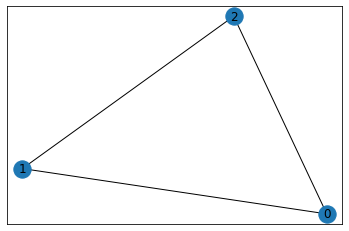

In [25]:
#Geração do grafo para alocação de registradores

import networkx as nx
import matplotlib.pyplot as plt
import itertools
   

class GraphVisualization:
   
    def __init__(self):
        self.visual = []
          
    
    def addEdge(self, a, b):
        temp = [a, b]
        self.visual.append(temp)

    def visualize(self):
        self.graph = nx.Graph()
        self.graph.add_edges_from(self.visual)
        nx.draw_networkx(self.graph)
        plt.show()
        
        
G = GraphVisualization()

#para cada instrução intermediária e análise de longevidade correspondente
for (instr,live) in ic_la:
    edges = itertools.combinations(live, 2) #cria as arestas, com base na análise de longevidade
    for (a,b) in edges:
        G.addEdge(a,b) #adiciona as arestas ao grafo
        
G.visualize()

In [26]:
colors = nx.coloring.greedy_color(G.graph, strategy="largest_first")

if colors == {}:
    colors={0:0}
    

print("posição:registrador\n", colors)

r_8086=["ax","bx","cx","dx"] #registradores para a arquitetura 8086

posição:registrador
 {0: 0, 1: 1, 2: 2}


In [27]:
#GERAÇÃO DE CÓDIGO FINAL PARA ARQUITETURA 8086


def Intel8086Code(ic_la):
    fc = [] #código final
    t=0
    oprs=["add","sub","mul","div"]
    
    #para cada linha de código intermediario
    for i,_ in ic_la:
        instruction, op1, op2 = i.split() #quebra a linha em instrução e operandos
        
        #gera código para armazenar conteúdo da memória dos registradores
        if instruction=="lit" or instruction=="lod" or instruction=="cal":
            fc.append("{} {} , {}". format("mov", r_8086[colors[t]], op2))
            t=t+1
        
        #gera código para armazenar conteúdo dos registradores na memória
        elif instruction=="sto":
            t=t-1
            fc.append("{} {} , {}". format("mov", op2, r_8086[colors[t]]))
            
        #gera código para a realização de operações artiméticas    
        elif instruction=="opr":
            t=t-1
            fc.append("{} {} , {}". format(oprs[int(op2)-2], r_8086[colors[t-1]], r_8086[colors[t]]))
            
    return fc


In [28]:
#TESTANDO A GERAÇÃO DE CÓDIGO FINAL PARA A ARQUITETURA 8086

fc = Intel8086Code(ic_la) #código final

for instruction in fc:
    print(instruction)
    

mov ax , func1
mov bx , 2
mov cx , 1
add bx , cx
mov localInt1 , bx
mov bx , globalInt2
mov cx , 4
sub bx , cx
mov globalInt3 , bx
mov bx , 1
mov globalInt3 , bx
mov globalBool1 , ax
mov ax , globalInt1
mov bx , 10
mul ax , bx
mov globalInt4 , ax
mov ax , globalInt2
mov bx , 3
div ax , bx
mov globalInt3 , ax
